### Chlorophyll A vs chemicals - code only

**Preprocessing**

In [1]:
#Libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import datetime as dt


%matplotlib inline

In [2]:
#Read datafile
df = pd.read_csv('../data/data_clean.csv', error_bad_lines=False)

In [3]:
#List of parameters to be removed - kept in seperate file for convenience
remove_pars = pd.read_csv('../data/remove_cols.csv', header=None)
remove_pars_list = remove_pars[0].tolist()

In [4]:
#Overwrite datafile with filtered version, then fix PAR column for our purposes
df = df[~df.PAR.isin(remove_pars_list)]
df['PAR'] = df['PAR'] + ' ' + df['EHD'] + ' ' + df['HDH']
df.drop(columns=['Unnamed: 0'], inplace=True)
#Repair broken datetime field
df.DATETIME = pd.to_datetime(df.DATETIME)

**Development of Chlorophyll A in The Netherlands**

In [5]:
#Create the dataframe that only contains chlf-A, and remove one location that has too much influence on the trend
chlf_ts = df[(df.PAR == 'CHLFa ug/l NVT') & (df.BGC != '<') & (df.LOC != 'STEILBK')][['DATETIME', 'WAARDE']]
chlf_ts['DATETIME'] = pd.to_datetime(chlf_ts['DATETIME'])
chlf_ts.index = chlf_ts.DATETIME
chlf_ts.drop(columns=['DATETIME'], inplace=True)

#Resample with monthly means - we need equal spacing for time series, after all. 
chlf_ts = chlf_ts.resample('M').mean()

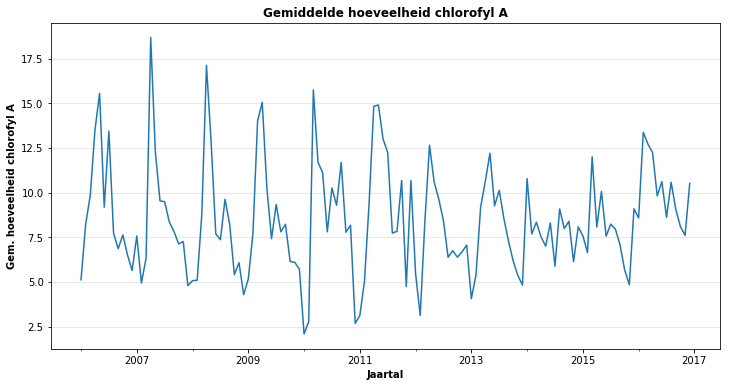

In [6]:
#Quick overview
fig, ax=plt.subplots(figsize=(12,6))
chlf_ts.plot(ax=ax, legend=False)
ax.set_xlabel("Jaartal", fontweight='bold')
ax.set_ylabel("Gem. hoeveelheid chlorofyl A", fontweight='bold')
ax.set_title("Gemiddelde hoeveelheid chlorofyl A", fontweight='bold', fontsize=12)
ax.yaxis.grid(color='lightgray', linestyle='-', linewidth=0.5 )
ax.set_axisbelow(True)
plt.savefig('../img/mean_chlfa_unfiltered.png')

None

In [7]:
#Store the CSV somewhere to load in R for time series
chlf_ts.to_csv('../data/chlf_ts.csv')

**Correlations Chlf-A**

In [8]:
#Create pivot table with multi-index
df_pivot_pars = df.pivot_table(index=['DATETIME', 'LOC'], values='WAARDE', columns='PAR')

In [9]:
#Calculate correlation matrix
correlated_pars = df_pivot_pars.corr()

In [10]:
#Filter relevant correlations
chlf_a_corrs = correlated_pars['CHLFa ug/l NVT']

In [11]:
#Only keep the strongest correlations
strong_neg_corrs = chlf_a_corrs.sort_values()[0:15]
strong_pos_corrs = chlf_a_corrs.sort_values(ascending=False)[1:15]

In [12]:
#How often do the chemicals with strong correlations to chlf-A appear in the data?
pos_corr_counts = [df_pivot_pars[x].notnull().sum() for x in strong_pos_corrs.index]
neg_corr_counts =[df_pivot_pars[x].notnull().sum() for x in strong_neg_corrs.index]

In [13]:
#Create new dataframes with strong/weak corrs and their counts

#Positive
strong_positive_df = pd.DataFrame({"Chemical": strong_pos_corrs.index,
                                          "Correlation": strong_pos_corrs.values, 
                                          "No of Observations": pos_corr_counts})
strong_positive_df.set_index('Chemical', inplace=True)

#Negative
strong_negative_df = pd.DataFrame({"Chemical": strong_neg_corrs.index,
                                          "Correlation": strong_neg_corrs.values, 
                                          "No of Observations": neg_corr_counts})
strong_negative_df.set_index('Chemical', inplace=True)

In [14]:
#Carbuforan has been found while it really shouldn't be - are the concentrations relevant?
df[df.PAR == 'cbfrn ug/l NVT'].BGC.value_counts()

<    454
Name: BGC, dtype: int64

**PCDD's, PCB's en PCDF's: Dioxins in The Netherlands**

In [15]:
#Subset of all data that contains dioxins
df_dioxins = df[(df.PAR.str.contains('PCB')) | (df.PAR.str.contains('PCDF')) | (df.PAR.str.contains('PCDD'))]

In [16]:
#Filter out all measurements of dioxins that are below the reporting treshold
df_dioxins = df_dioxins[df_dioxins.BGC != '<']

In [17]:
#Repair datetime field
df_dioxins['DATETIME'] = pd.to_datetime(df_dioxins['DATETIME'])

In [18]:
#Categorise values to make EHD irrelevant
quantiles_dioxins = pd.qcut(df_dioxins[df_dioxins.EHD == 'ug/kg'].WAARDE, 5, labels=False)
quantiles_dioxins = quantiles_dioxins.append(pd.qcut(df_dioxins[df_dioxins.EHD == 'ug/l'].WAARDE, 5, labels=False))
quantiles_dioxins = quantiles_dioxins.append(pd.qcut(df_dioxins[df_dioxins.EHD == 'ng/kg'].WAARDE, 5, labels=False))
df_dioxins = pd.concat([df_dioxins, quantiles_dioxins], axis=1)
df_dioxins['QUANTILE'] = df_dioxins.iloc[:,-1]
df_dioxins.drop(df_dioxins.columns[-2], axis=1, inplace=True)

In [19]:
#Convert df_dioxins to a GeoDataFrame for visualization
dioxins_geometry = [Point(xy) for xy in zip(df_dioxins.X_RD, df_dioxins.Y_RD)]
dioxins_geo_df = gpd.GeoDataFrame(df_dioxins, geometry=dioxins_geometry)

In [48]:
#Read NL map
nl_map = gpd.read_file('../data/shapefiles/2018-Imergis_provinciegrenzen_kustlijn.shp')
nl_rivers = gpd.read_file('../data/shapefiles/NL-water-simpel.shp')

In [50]:
#Plotting function
def plot_this_year(year):
    '''Takes a year (that is within the Geodataframe, of course) and uses it to visualize locations
    where the highest concentrations of dioxins were measured. Annotations will only be placed on locations
    with the highest quantile of concentrations.
    
    Returns the slice of the geo_df that was used in order to make it available for further analysis.'''
    #Annotation box props
    bbox_properties = dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=2)
    
    #DF manipulation
    geo_df_slice = dioxins_geo_df[dioxins_geo_df.DATETIME.dt.year == year]
    quantile_values = pd.DataFrame(geo_df_slice.groupby('LOC').QUANTILE.agg('mean'))
    geo_df_slice = geo_df_slice.merge(quantile_values, left_on='LOC', right_index=True)
    geo_df_slice['new_quantiles'] = pd.qcut(geo_df_slice.QUANTILE_y, 5, labels=False)
    
    #Plotting
    fig, ax = plt.subplots(figsize=(14,14), subplot_kw={'aspect':'equal'})
    ax.set_xlim(0,300000)
    ax.set_title("Dioxin pollution in quantiles, " + str(year), fontweight='bold')
    ax.set_ylim(300000,650000)
    ax.set_axis_off()
    nl_map.plot(ax=ax, edgecolor='darkgrey', linewidth=0.3)
    nl_rivers.plot(ax=ax, alpha=0.9, color='white')
    geo_df_slice.plot(ax=ax, cmap='RdYlGn_r',alpha=0.8, column='new_quantiles', scheme='quantiles', markersize=100)
    
    #Annotation - manually locates several labels elsewhere on the map. 
    annotated_locs = []
    for i, txt in enumerate(geo_df_slice.LOCOMS.tolist()):        
        if geo_df_slice.iloc[i, -1] > 3:
            if geo_df_slice.iloc[i, 1] not in annotated_locs:
                if (txt == "Beerkanaal midden"):
                    ax.text(s=txt, 
                            x=geo_df_slice.iloc[i,-8] - 15000,
                            y=geo_df_slice.iloc[i,-7] - 5500, 
                           fontweight='bold', 
                           bbox=bbox_properties)
                    annotated_locs.append(geo_df_slice.iloc[i, 1])
                elif (txt != 'Nieuwegein') & (txt != "Westzaan (kilometer 13)"):
                    ax.text(s=txt, 
                            x=geo_df_slice.iloc[i,-8],
                            y=geo_df_slice.iloc[i,-7] - 4500, 
                           fontweight='bold', 
                           bbox=bbox_properties)
                    annotated_locs.append(geo_df_slice.iloc[i, 1])
                else:
                    ax.text(s=txt, 
                            x=geo_df_slice.iloc[i,-8],
                            y=geo_df_slice.iloc[i,-7] + 3500, 
                           fontweight='bold', 
                           bbox=bbox_properties)
                    annotated_locs.append(geo_df_slice.iloc[i, 1])
 
                    
    return geo_df_slice



In [25]:
#Manual list of interesting locations for later use
locs_of_interest = ['Nieuwegein', 'Gouda voorhaven', 'Nederweert', 'Schaar van Ouden Doel', 'Sas van Gent',
                   'Haringvlietsluis','Brienenoord (kilometer 996.5)', 'Nieuwersluis', 'Puttershoek', 'Keizersveer',
                   'Belfeld boven']

In [51]:
#Creates a dict with the top "polluted" locations per year.
#Also creates a new dataframe with locations for visualization for later. 
annotated_locations_yearly = {}
quantiled_dioxins_df = pd.DataFrame()

#Plot each year, save the figure, and build a special quantiled dataframe while we're at it. 
for year in dioxins_geo_df.DATETIME.dt.year.unique():
    x = plot_this_year(year)
    plt.savefig('../img/dioxins_concentration_' + str(year) + '.png')
    annotated_locations_yearly.update({year: x[x.new_quantiles > 3].LOCOMS.unique()})
    quantiled_dioxins_df = pd.concat([quantiled_dioxins_df, x])
    #Suppress output for now
    plt.close()

In [52]:
#Populate a list, where each entry is the quantile for a location in a year
quantile_change_locs = []
for year in dioxins_geo_df.DATETIME.dt.year.unique():
    for loc in locs_of_interest: 
        quantile_change_locs.append([loc,quantiled_dioxins_df[(quantiled_dioxins_df.DATETIME.dt.year == year) &
                            (quantiled_dioxins_df.LOCOMS == loc)].new_quantiles.mean(), year])


In [53]:
#Convert said list to dataframe and pivot for plotting purposes. 
quantile_change_locs = pd.DataFrame(quantile_change_locs).fillna(0)
quantile_change_plottable = quantile_change_locs.pivot_table(index=0, values=1, columns=[2])
quantile_change_plottable.index.name=None
quantile_change_plottable.columns.name=None

In [54]:
#Sort and visualize
quantile_change_plottable.sort_values(by=[2016, 2015, 2014], ascending=False, inplace=True)
quantile_change_plottable.style.background_gradient(cmap='RdYlGn_r')

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Brienenoord (kilometer 996.5),3,3,3,3,1,3,4,4,4,4,4
Gouda voorhaven,4,4,4,4,4,4,4,4,4,4,4
Nieuwegein,4,4,4,4,4,4,4,4,4,4,4
Puttershoek,3,3,3,0,1,3,3,3,4,4,4
Sas van Gent,4,3,4,4,3,3,4,4,4,4,4
Schaar van Ouden Doel,3,4,3,4,3,3,4,4,4,4,4
Nederweert,4,4,4,4,2,2,3,4,3,4,4
Nieuwersluis,0,0,0,0,2,3,4,4,4,3,4
Belfeld boven,4,3,3,0,4,3,3,1,1,1,3
Haringvlietsluis,4,4,4,4,3,2,2,2,2,2,1


**Lanthanides**

In [55]:
#Manual list of lanthanides found earlier
lanthanide_list = ['Gd mg/kg dg', 'Yb mg/kg dg', 'Er mg/kg dg', 'Tm mg/kg dg', 'Ho mg/kg dg', 'Dy mg/kg dg']

In [56]:
#Create DF with just lanthanides
df_lanthanides = df[df.PAR.isin(lanthanide_list)]
df_lanthanides['DATETIME'] = pd.to_datetime(df_lanthanides['DATETIME'])

#Instantiate geo-df
lanthanides_geometry = [Point(xy) for xy in zip(df_lanthanides.X_RD, df_lanthanides.Y_RD)]
lanthanides_geo_df = gpd.GeoDataFrame(df_lanthanides, geometry=lanthanides_geometry)


C:\Users\youri\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


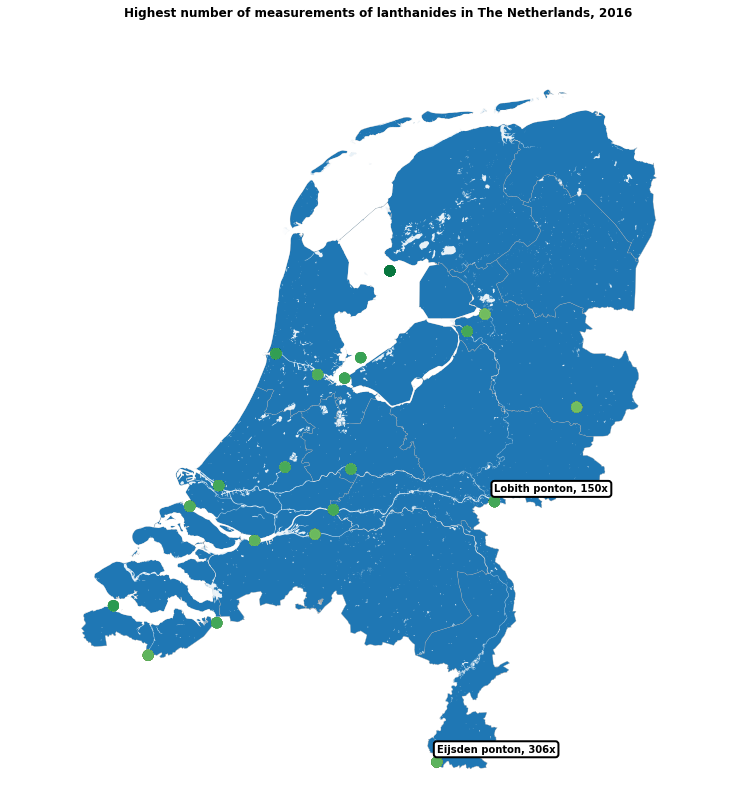

In [58]:
#Filter DF and set textbox props
lanthanides_2016 = lanthanides_geo_df[lanthanides_geo_df.DATETIME.dt.year == 2016]
bbox_properties = dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=2)

#Plot
fig, ax = plt.subplots(figsize=(14,14), subplot_kw={'aspect':'equal'})
ax.set_xlim(0,300000)
ax.set_ylim(300000,650000)
ax.set_axis_off()
ax.set_title("Highest number of measurements of lanthanides in The Netherlands, 2016", fontweight='bold')
nl_map.plot(ax=ax, edgecolor='darkgrey', linewidth=0.3)
nl_rivers.plot(ax=ax, alpha=0.9, color='white')
lanthanides_2016.plot(ax=ax, cmap='RdYlGn_r',alpha=0.8, column='WAARDE', markersize=100)

#Annotate
annotated_locs = []
for i, txt in enumerate(lanthanides_2016.LOCOMS.tolist()):        
    if lanthanides_2016.iloc[i, 1] not in annotated_locs:
        if lanthanides_2016.LOCOMS.value_counts()[txt] > 100:
            ax.text(s=txt + ', ' + str(lanthanides_2016.LOCOMS.value_counts()[txt]) + 'x', 
                    x=lanthanides_2016.iloc[i,-5],
                    y=lanthanides_2016.iloc[i,-4] + 4500, 
                   fontweight='bold', 
                   bbox=bbox_properties)
            annotated_locs.append(lanthanides_2016.iloc[i, 1])
            
plt.savefig('../img/lanthanides.png')